In [1]:
!pip install stopwords apache_beam[gcp]

import tensorflow as tf

import numpy as np

import stopwords, csv, warnings, os, urllib

from tensorflow.keras import layers, models

warnings.filterwarnings("ignore")

In [2]:
unlist = stopwords.get_stopwords("english")

def HelperClear(sentences):
  """
  Helper to Clear Your Sentences
  """
  output = sentences.lower().split()
  unlist = stopwords.get_stopwords("english")
  output = [i for i in output if i not in unlist]
  result = " ".join(output)
  return result

In [3]:
urlfile = "bbc-text.csv"

sentences = []; labels = []

with open(urlfile, 'r') as urli:
  reader = csv.reader(urli, delimiter=",")
  next(reader)
  for input in reader:
    labels.append(input[0])
    sentences.append(HelperClear(input[1]))

In [4]:
TotalToken = 1000

OutputLength = 120

In [5]:
train_split = int(0.8 * len(sentences))

train_input = sentences[:train_split]

validate_input = sentences[train_split:]

In [6]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=TotalToken, output_sequence_length=OutputLength)

vectorizer.adapt(train_input)

In [7]:
train_input = vectorizer(train_input)

validate_input = vectorizer(validate_input)

In [8]:
train_label = labels[:train_split]

validate_label = labels[train_split:]

In [9]:
from tensorflow.keras.layers import StringLookup

label_encoder = StringLookup(num_oov_indices=0)

label_encoder.adapt(train_label)

In [10]:
train_label = np.array(label_encoder(train_label))

validate_label = np.array(label_encoder(validate_label))

In [11]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Embedding, GlobalAvgPool1D, Dense

model = tf.keras.models.Sequential([
  Embedding(TotalToken, 16, input_length=OutputLength),
  GlobalAvgPool1D(),
  Dense(16, activation="relu"),
  Dense(5, activation="softmax")
])

loss = "sparse_categorical_crossentropy"

model.compile(loss=loss, optimizer="adam", metrics=['accuracy'])

In [12]:
hist = model.fit(train_input, train_label, validation_data=(validate_input, validate_label), epochs=10)

In [13]:
model.evaluate(train_input, train_label, verbose=False)

[0.23993299901485443, 0.966292142868042]

In [14]:
model.evaluate(validate_input, validate_label, verbose=False)

[0.3285224139690399, 0.9303370714187622]

In [15]:
if not os.path.exists("Helplot.py"):

  giturl = "https://raw.githubusercontent.com/Kelniit/Hut/refs/heads/main/Helplot.py"

  urllib.request.urlretrieve(giturl, "Helplot.py")

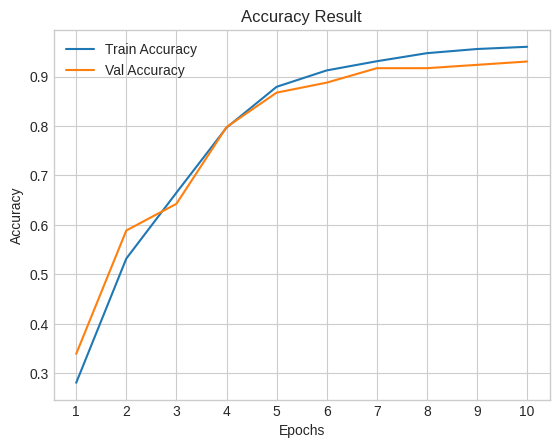

In [16]:
from Helplot import Helplot

plot = Helplot(hist)

plot.Relplot

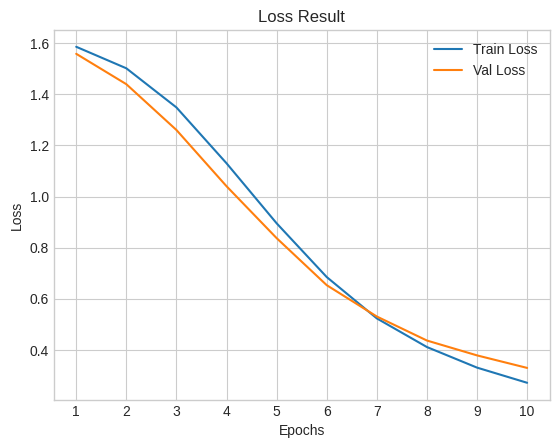

In [17]:
plot.Falplot

In [ ]:
model.save("/content/model.h5")

In [19]:
from apache_beam.ml.inference.tensorflow_inference import TFModelHandlerTensor

from apache_beam.ml.inference.base import RunInference

In [20]:
ModelTensor = TFModelHandlerTensor("/content/model.h5", compile=False)

test_logits = validate_input[:10]

In [ ]:
import apache_beam as beam

labeler = lambda result : np.argmax(result.inference.numpy(), axis=0)

with beam.Pipeline() as pipeline:
  runner = (
    pipeline
    | 'Create' >> beam.Create(test_logits)
    | 'RunInference' >> RunInference(ModelTensor)
    | 'Outer' >> beam.Map(labeler)
    | 'Unlist' >> beam.combiners.ToList()
    | 'Output' >> beam.io.WriteToText("/content/result.txt")
  )

In [22]:
!cat /content/result.txt-00000-of-00001

[3, 4, 2, 0, 0, 4, 1, 3, 3, 3]


In [23]:
validate_label[:10]

array([3, 4, 2, 0, 0, 4, 1, 4, 3, 3])